## LSST Afterglow detection metrics

Notebook for a mocked up GRB afterglow lightcurve. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db

### On-axis afterglows

On-axis afterglows decay as $F \sim t^{-\alpha}$ until a jet break, with $\alpha \sim 1$.

This requires subclassing `TransientMetric`, which assumes linear rise & decays in magnitude. We therefore have writted `GRBTransientMetric` that synthesizes the appropriate lightcurve shape.

We will use the rough numbers in 2011PASP..123.1034J: a Gaussian with $\mu$=15.35 mag, $\sigma=1.59$ in R-band at 1 minute after explosion, $\alpha = 1.0$.  
The right way to do this is not to assume fiducial values, but to simulate a cosmological population of events.


### GRBTransientMetric

In [62]:
from mafContrib import GRBTransientMetric

Let's look at a single year of the survey--we'll normalize our detection rates per year.

In [4]:
year = 8

Now let's plot the lightcurves.  Because we include a random draw from the brightness distribution these plots will change each time we re-execute the cell.

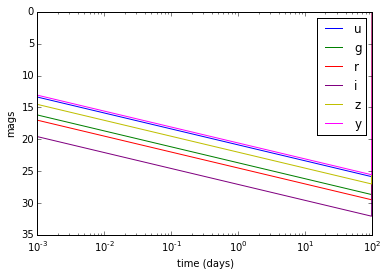

In [39]:
colors = ['b','g','r','purple','y','magenta','k']
filterNames = ['u','g','r','i','z','y']

transDuration = 100 # days--controls how frequently we inject new transients.
transMetric = GRBTransientMetric(alpha= 1.,surveyDuration=1, transDuration=transDuration)


times = np.logspace(-3,2,500)
for filterName, color in zip(filterNames,colors):
    filters = np.array([filterName]*times.size)
    lc = transMetric.lightCurve(times % transDuration,filters)
    plt.plot(times,lc, color, label=filterName)
plt.xlabel('time (days)')
plt.ylabel('mags')
plt.gca().invert_yaxis()
plt.xscale('log')
plt.legend()

In [40]:
# Pick a slicer
slicer = slicers.HealpixSlicer(nside=64)

summaryMetrics = [metrics.MedianMetric()]
# Configure some metrics
metricList = []
# What fraction of transients are detected at least once?
metricList.append(transMetric)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [41]:
# Set the database and query
runName = 'enigma_1189'
sqlconstraint = 'night between %f and %f' % ((365.25*year,365.25*(year+1)))
# sqlconstraint='night > 0' # needed to get Plane, NEP extensions, but screws up rate calc?
bDict={}
for i,metric in enumerate(metricList):
    bDict[i] = metricBundles.MetricBundle(metric, slicer, sqlconstraint, 
                                          runName=runName, summaryMetrics=summaryMetrics)

Querying database with constraint night between 2922.000000 and 3287.250000
Found 250549 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting.
monopole: 0.50926  dipole: lon: 87.6616, lat: -38.0385, amp: 0.134698
Plotting complete.


/home/maf/miniconda/lib/python2.7/site-packages/sqlalchemy/sql/elements.py:3759: SAWarning: Textual SQL expression 'night between 2922.000000...' should be explicitly declared as text('night between 2922.000000...') (this warning may be suppressed after 10 occurrences)
  {"expr": util.ellipses_string(element)})


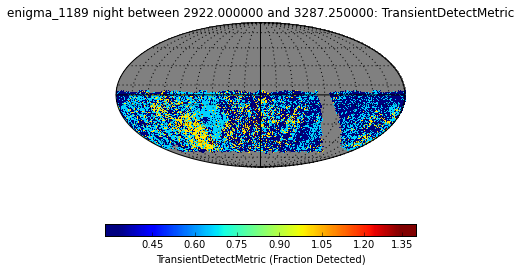

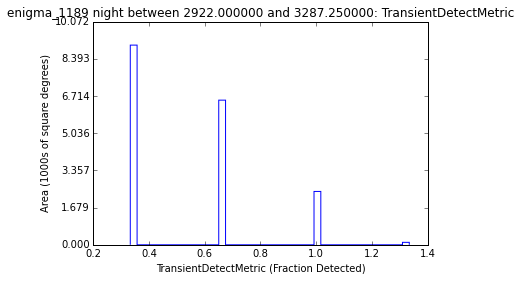

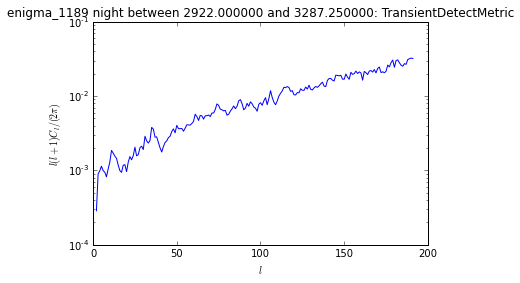

In [42]:
opsdb = db.OpsimDatabase(runName + '_sqlite.db')
outDir = 'Transients'
resultsDb = db.ResultsDb(outDir=outDir)

bgroup = metricBundles.MetricBundleGroup(bDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)

In [43]:
for key in bDict:
    bDict[key].computeSummaryStats(resultsDb=resultsDb)
    print bDict[key].metric.name, bDict[key].summaryValues

TransientDetectMetric {'Median': 0.66666666666666663}


So about two thirds of these afterglows would be detected in at least one epoch.

Now ask how many we can detect with 3 points per lightcurve (no restriction on same band, because TransientMetric doesn't allow it.)

In [50]:
transMetric = GRBTransientMetric(alpha= 1., surveyDuration=1, nPerLC=3)

sqlconstraint = 'night between %f and %f' % (365.25*year,365.25*(year+1))
transBundle = metricBundles.MetricBundle(transMetric, slicer, sqlconstraint, 
                                          runName=runName, summaryMetrics=summaryMetrics)

Querying database with constraint night between 2922.000000 and 3287.250000
Found 250549 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting.
monopole: 0.0419802  dipole: lon: -53.2907, lat: 40.6095, amp: 0.00492844
Plotting complete.


/home/maf/miniconda/opt/lsst/sims_maf/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:298: RuntimeWarning: invalid value encountered in equal
  b.metricValues.mask = np.where(b.metricValues.data==b.metric.badval,


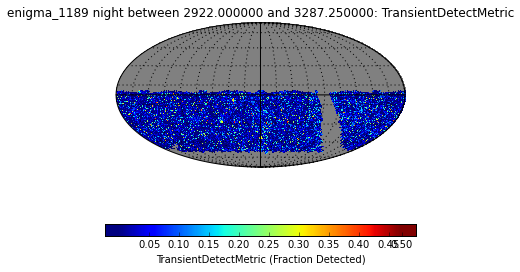

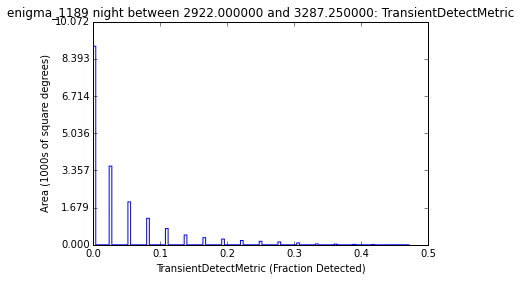

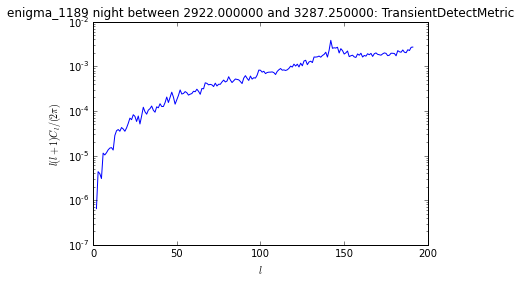

In [52]:
bgroup = metricBundles.MetricBundleGroup({0:transBundle}, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)


In [53]:
transBundle.summaryValues

{'Median': 0.027777777777777776}

So demanding three detections (in any filter) drops us to a 3% median detection rate.  Two detections is at 11%

### TripletBandMetric

Now let's look more generically at how often we have three observations in a single filter within a relevant interval to detect a GRB.

We'll start by determining how long LSST can observe afterglows parameterized as above--this is be band-dependent, as both LSST's limiting magnitude and the afterglow color vary.  For simplicity we consider just $r$ band for now.

3.67444190906


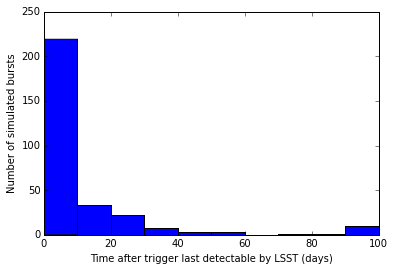

In [37]:
colors = ['b','g','r','purple','y','magenta','k']
filterNames = ['u','g','r','i','z','y']

transDuration = 300 # days--controls how frequently we inject new transients.
transMetric = GRBTransientMetric(alpha= 1.,surveyDuration=1, transDuration=transDuration)



def find_time_at_limiting_mag(limiting_mag,times,lc):
    return np.interp(limiting_mag,lc,times)

limit_times = []
lc_mins = []
#times = np.linspace(0,transDuration+1,500)
times = np.logspace(-2,2,500)
for i in range(300):
    # since we haven't included band-dependent afterglow brightness yet, 
    # look at the brightness distribution as a function of time in a single band
    filters = np.array(['r']*times.size)
    lc = transMetric.lightCurve(times,filters)
    lc_mins.append(lc[-1])
    limit_times.append(find_time_at_limiting_mag(24.7,times,lc))
#    plt.plot(times,lc)
#plt.xlabel('time (days)')
#plt.ylabel('mags')
#plt.gca().invert_yaxis()
#plt.xscale('log')
plt.hist(limit_times)
plt.xlabel('Time after trigger last detectable by LSST (days)')
plt.ylabel('Number of simulated bursts')

print np.percentile(limit_times,50)

So there is a substantial tail of afterglows detectable to tens or even hundreds of days after the burst.  Let's look at the cumulative histogram:

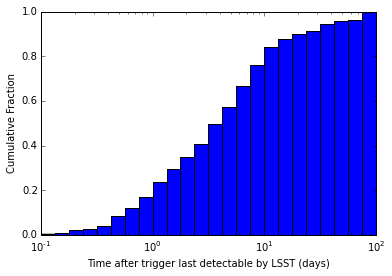

In [36]:
plt.hist(limit_times,normed=True,cumulative=True,bins=np.logspace(-1,2,25))
plt.xscale('log')
plt.xlabel('Time after trigger last detectable by LSST (days)')
plt.ylabel('Cumulative Fraction')

It is important to remember that we have not included a jet break in our lightcurve model here--in reality we expect the afterglow decay to decay faster at late times.  Let's adopt 10 days as the maximum detectable time for most bursts, and see how well the TripletDetectionMetric does:

In [72]:
from mafContrib import TripletBandMetric

In [73]:
triplet = TripletBandMetric(
    DelMin=0.5, # at least half an hour separation between observations
    DelMax=10*24.) # at most ten days (-> hours) separation between observations


In [74]:
# Pick a slicer
slicer = slicers.HealpixSlicer(nside=64)

summaryMetrics = [metrics.MedianMetric()]
# Configure some metrics
metricList = []
# What fraction of transients are detected at least once?
metricList.append(triplet)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [75]:
# Set the database and query
runName = 'enigma_1189'
sqlconstraint = 'night between %f and %f' % ((365.25*year,365.25*(year+1)))
# sqlconstraint='night > 0' # needed to get Plane, NEP extensions, but screws up rate calc?
bDict={}
for i,metric in enumerate(metricList):
    bDict[i] = metricBundles.MetricBundle(metric, slicer, sqlconstraint, 
                                          runName=runName, summaryMetrics=summaryMetrics)

Querying database with constraint night between 2922.000000 and 3287.250000
Found 250549 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.

Cannot plot object metric values with this plotter.
Cannot plot object metric values with this plotter.
Cannot plot object metric values with this plotter.
Optimal bin calculation tried to make 128483 bins, returning 200



Plotting.
monopole: 3532.59  dipole: lon: 51.8988, lat: 8.49307, amp: 3456.22
monopole: 1915.44  dipole: lon: 58.9382, lat: 1.75379, amp: 1949.92

/home/maf/miniconda/opt/lsst/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
Optimal bin calculation tried to make inf bins, returning 200
Optimal bin calculation tried to make 84756 bins, returning 200



monopole: 768.98  dipole: lon: 38.1196, lat: 46.5669, amp: 1024.38
monopole: 391.04  dipole: lon: 49.6838, lat: -16.4237, amp: 420.251

Optimal bin calculation tried to make 92897 bins, returning 200
Optimal bin calculation tried to make 45859 bins, returning 200



monopole: 159.499  dipole: lon: 53.255, lat: -32.7222, amp: 159.405
monopole: 23.4251  dipole: lon: 50.3959, lat: -31.8615, amp: 28.6579

Optimal bin calculation tried to make 156487 bins, returning 200
Optimal bin calculation tried to make 44164 bins, returning 200



monopole: 274.203  dipole: lon: 38.2333, lat: -16.5416, amp: 256.375
Plotting complete.


/home/maf/miniconda/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


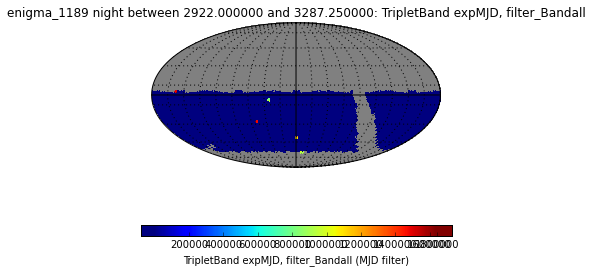

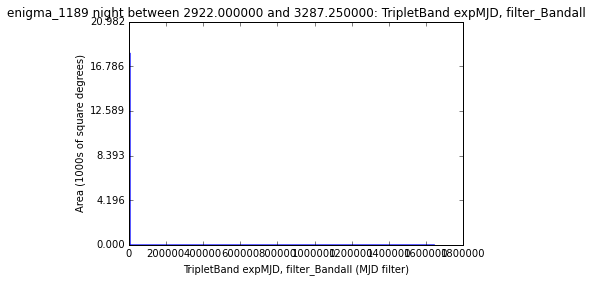

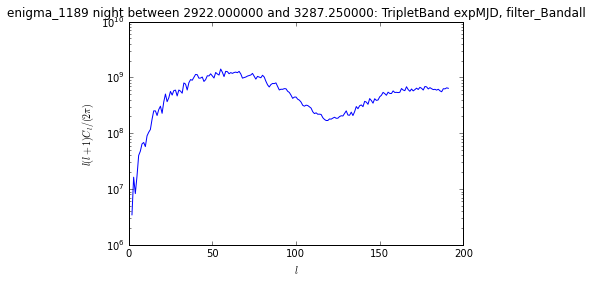

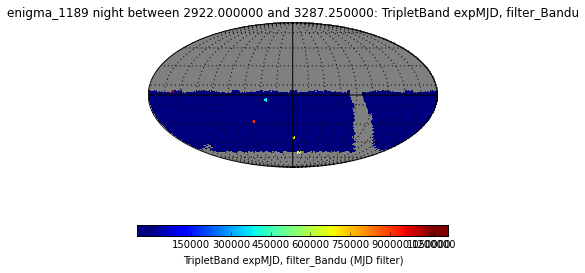

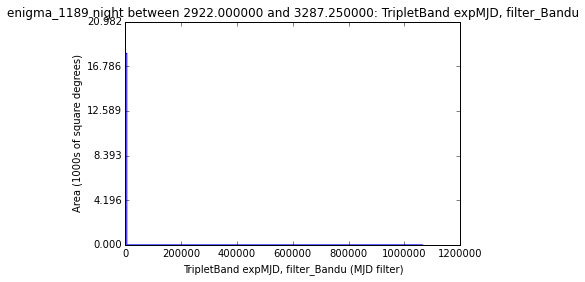

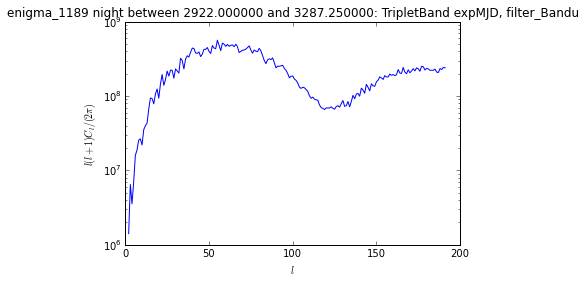

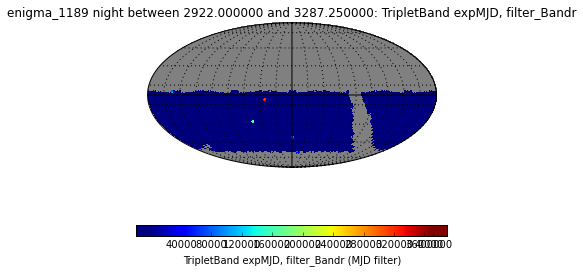

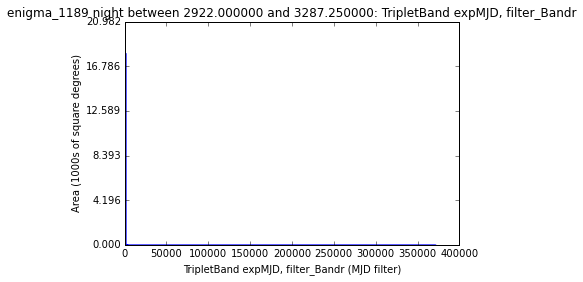

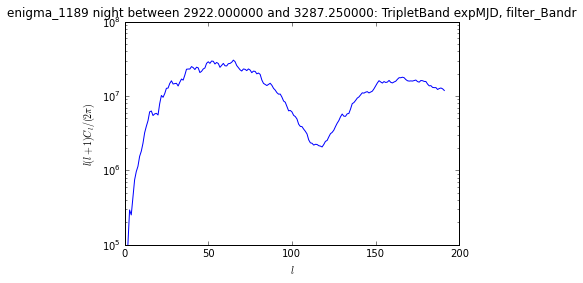

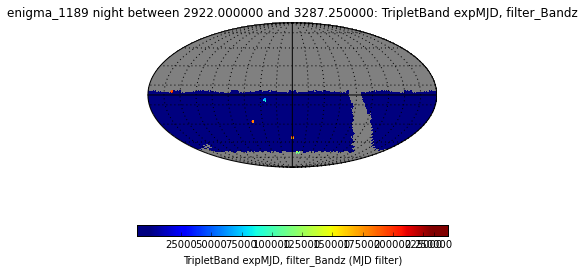

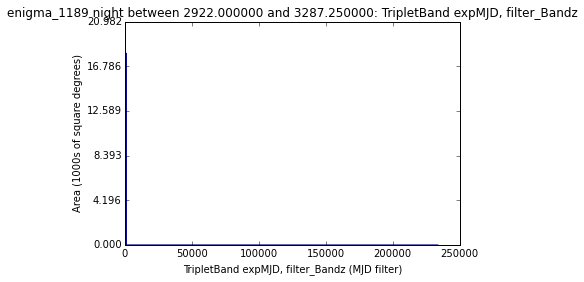

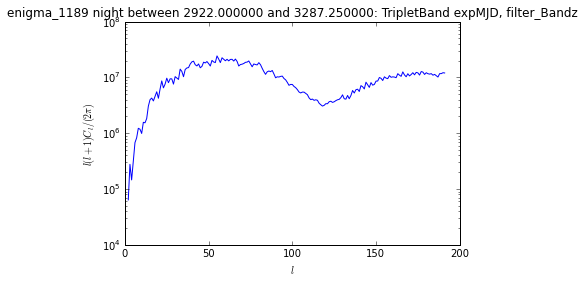

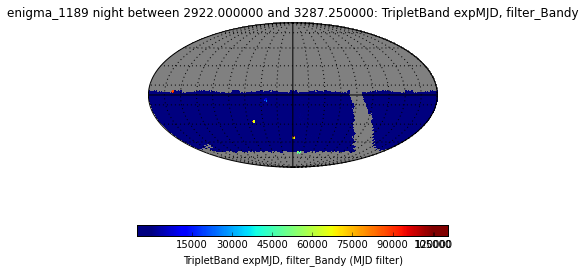

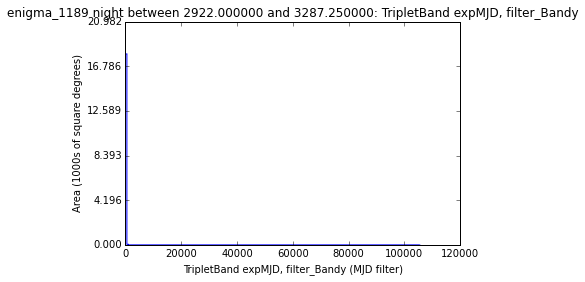

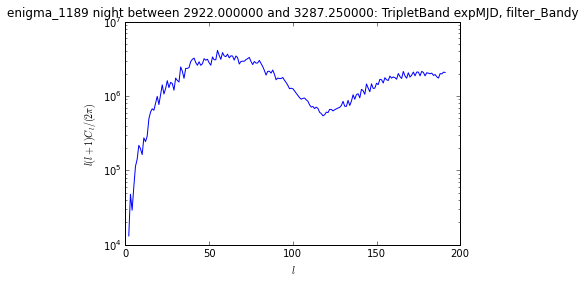

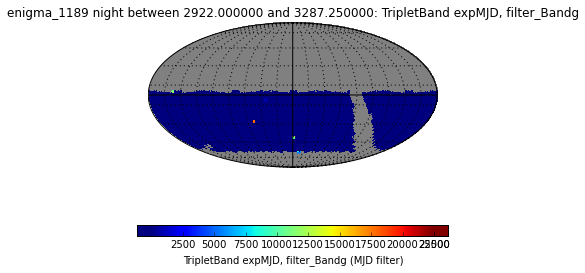

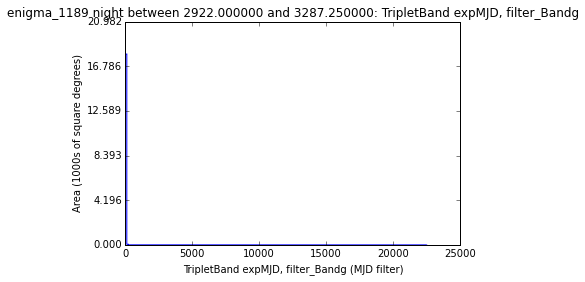

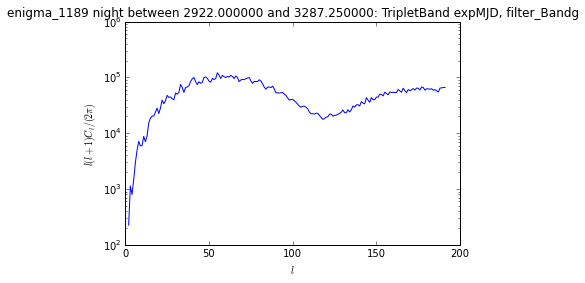

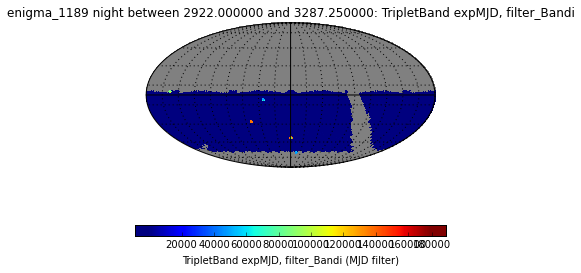

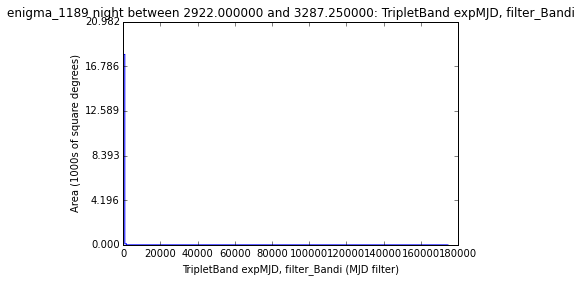

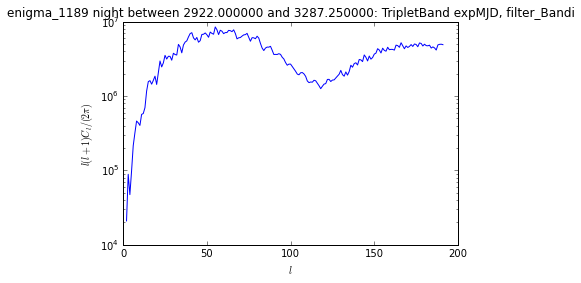

In [76]:
opsdb = db.OpsimDatabase(runName + '_sqlite.db')
outDir = 'Transients'
resultsDb = db.ResultsDb(outDir=outDir)

bgroup = metricBundles.MetricBundleGroup(bDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)

In [77]:
for key in bDict:
    bDict[key].computeSummaryStats(resultsDb=resultsDb)
    print bDict[key].metric.name, bDict[key].summaryValues

TripletBand expMJD, filter {}
TripletBand expMJD, filter_Bandall {'Median': 83.0}
TripletBand expMJD, filter_Bandu {'Median': 0.0}
TripletBand expMJD, filter_Bandr {'Median': 24.0}
TripletBand expMJD, filter_Bandz {'Median': 14.0}
TripletBand expMJD, filter_Bandy {'Median': 13.0}
TripletBand expMJD, filter_Bandg {'Median': 0.0}
TripletBand expMJD, filter_Bandi {'Median': 20.0}
